# Speech emotion recognition

# Imports

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import tensorflow_addons as tfa

import librosa
import librosa.display

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from os import listdir

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from IPython.display import Audio

# Constants

In [37]:
RAV_DATASET_PATH = "ravdess/"

In [38]:
emotions = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}

modality_map = {'01': 'full-AV', '02': 'video-only', '03': 'audio-only'}
vocal_channel_map = {'01': 'speech', '02': 'song'}
emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'}
intensity_map = {'01': 'normal', '02': 'strong'}
condition_map = {'01': '"Kids are talking by the door"', '02': '"Dogs are sitting by the door"'}
repetition_map = {'01': '1st repetition', '02': '2nd repetition'}

# Decoding a filename into data

In [39]:
def decode_filename(filename):
    parts = filename.split('.')[0].split('-')
    modality = parts[0]
    vocal_channel = parts[1]
    emotion = parts[2]
    intensity = parts[3]
    condition = parts[4]
    repetition = parts[5]
    actor = parts[6]

    decoded_filename = {
        'modality': modality_map[modality],
        'vocal_channel': vocal_channel_map[vocal_channel],
        'emotion': emotion_map[emotion],
        'intensity': intensity_map.get(intensity, 'N/A'),
        'condition': condition_map[condition],
        'repetition': repetition_map[repetition],
        'actor': actor
    }

    return decoded_filename

# Loading dataset into DataFrame

In [40]:
ravdess_directory_list = listdir(RAV_DATASET_PATH)
file_emotion, file_path = [], []
for dir in ravdess_directory_list:
    actor = listdir(RAV_DATASET_PATH + dir)
    for file in actor:
        decoded_filename = decode_filename(file)
        file_emotion.append(decoded_filename['emotion'])
        file_path.append(RAV_DATASET_PATH + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

In [41]:
Ravdess_df.head()

,Emotions,Path
0,neutral,ravdess/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,ravdess/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,ravdess/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,ravdess/Actor_01/03-01-01-01-02-02-01.wav
4,calm,ravdess/Actor_01/03-01-02-01-01-01-01.wav


# Distribution of features in a set

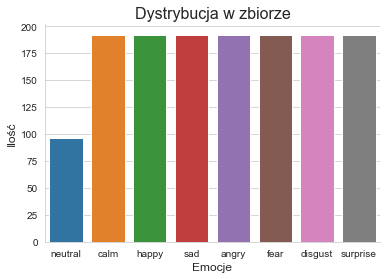

In [42]:
plt.title('Distribution of features in a set', size=16)
sns.countplot(Ravdess_df, x="Emotions")
plt.ylabel('Quantity', size=12)
plt.xlabel('Emotions', size=12)
sns.despine()
plt.show()

# Functions for displaying signal graphs

In [43]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Audio signal graph for {}'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Audio signal spectrogram for {}'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [44]:
def present_signals(emotion):
    path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)

# Presentation of audio signals and spectrograms

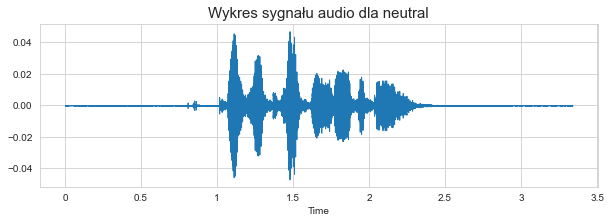

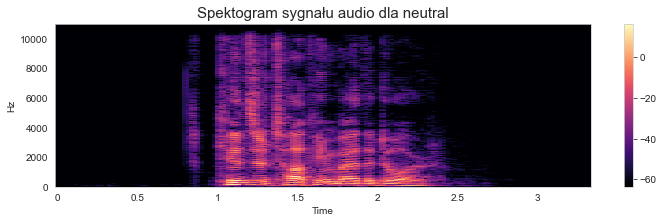

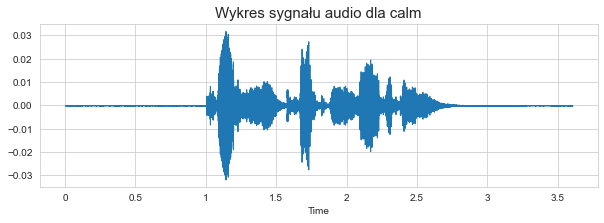

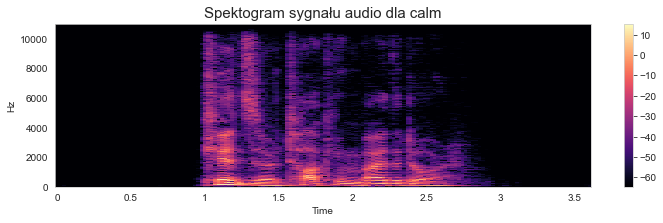

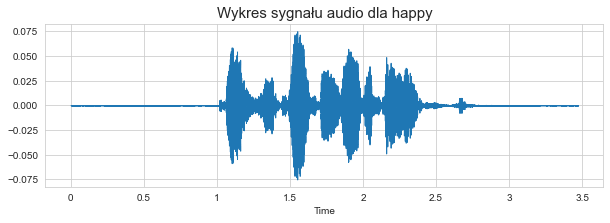

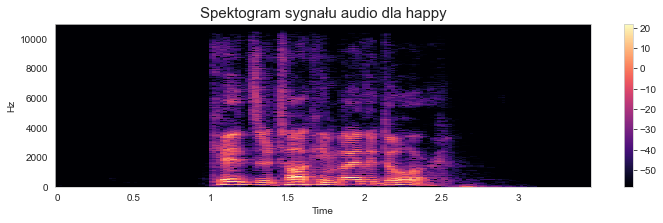

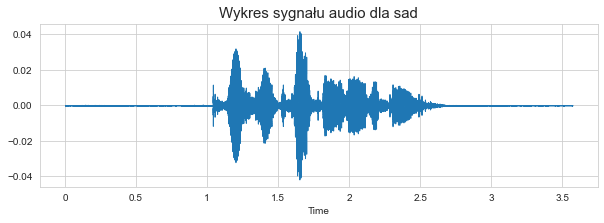

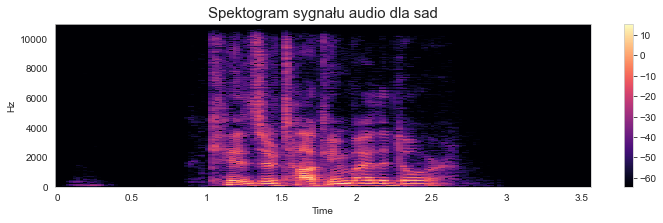

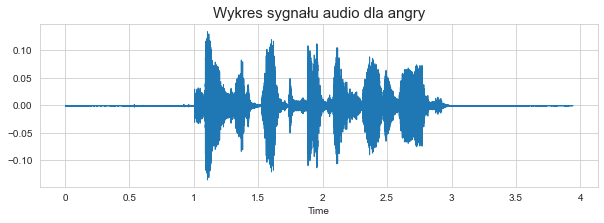

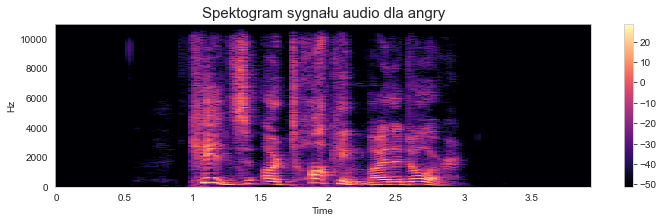

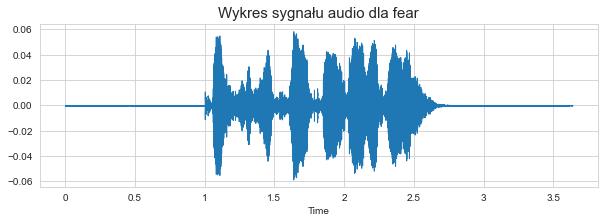

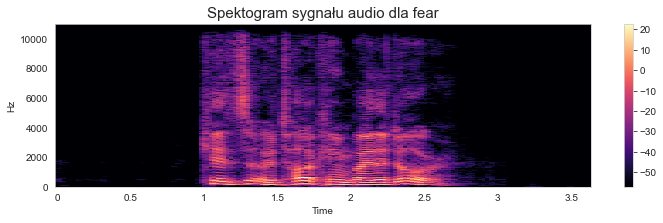

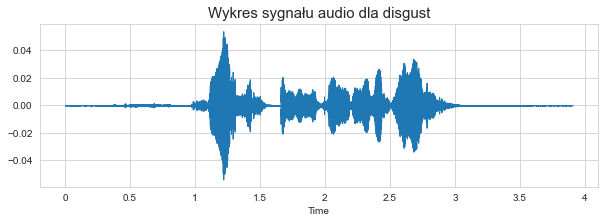

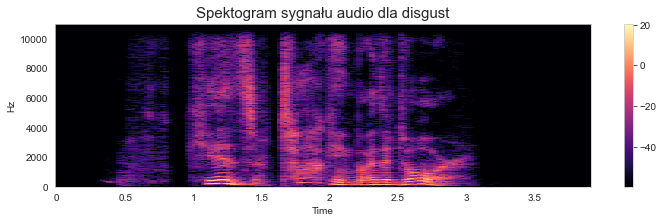

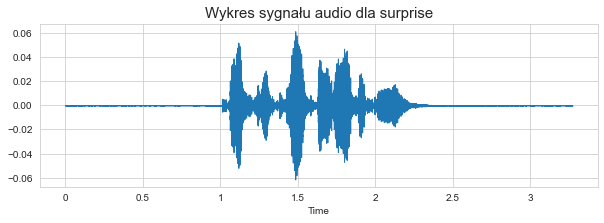

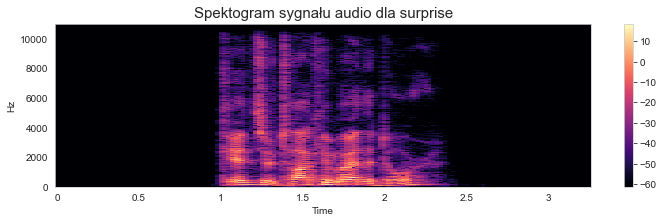

In [45]:
for emotion in emotions.values():
    present_signals(emotion)

# Data augmentation

In [46]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

# Sample of original audio

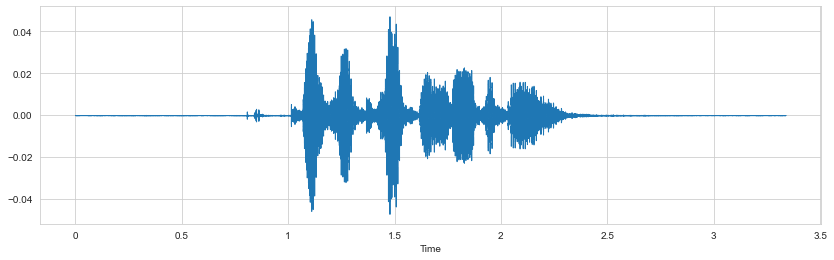

In [47]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

# Audio sample with noise

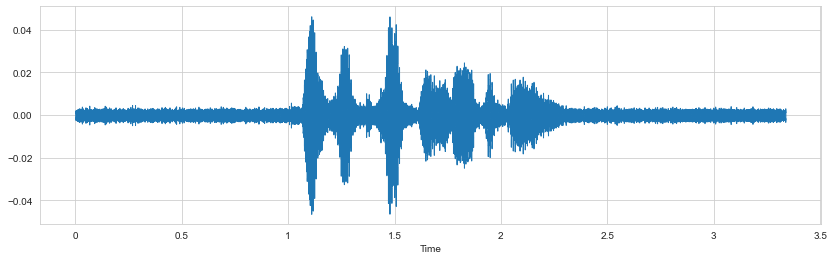

In [48]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Audio sample with "stretch"

C:\Users\Arkan\AppData\Local\Temp\ipykernel_15748\2138175121.py:7: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)


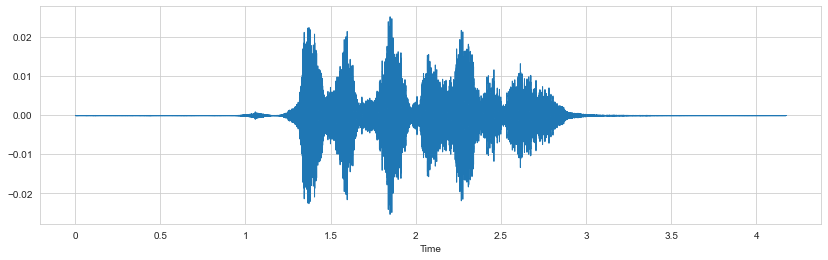

In [49]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Sound sample with higher tones

C:\Users\Arkan\AppData\Local\Temp\ipykernel_15748\2138175121.py:10: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


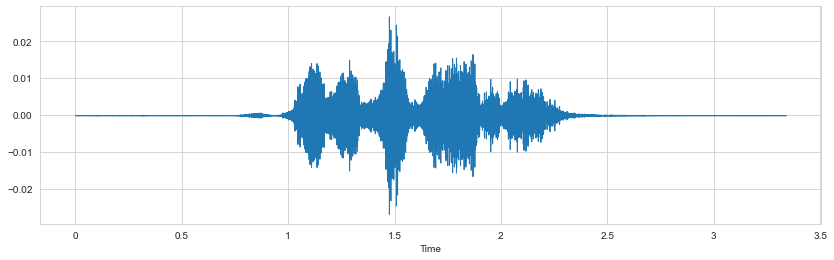

In [50]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature extraction

In [51]:
def extract_features(data):
    result = np.array([])

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    return result

In [52]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.5)

    ## no augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    ## noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    ## strech + pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))

    return result

In [53]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

C:\Users\Arkan\AppData\Local\Temp\ipykernel_15748\2138175121.py:7: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
C:\Users\Arkan\AppData\Local\Temp\ipykernel_15748\2138175121.py:10: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


# Saving features with classes to a separate file (feature extraction takes a long time)

In [55]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-647.205017,74.494820,-1.027088,18.256382,8.400715,2.474266,-6.123550,-2.492467,-16.309069,-2.110272,...,-2.432193,0.957063,-3.460787,-0.890993,2.436301,-6.758149,-1.168994,-2.999688,-0.060077,neutral
1,-631.951508,71.479923,-0.363607,17.418922,8.293015,2.309446,-5.869443,-3.048924,-15.936242,-2.602306,...,-2.141033,0.319418,-3.749488,-1.605392,2.250950,-6.688018,-1.661351,-2.622696,-0.405011,neutral
2,-714.374512,73.627441,-3.383080,19.450293,5.375023,1.764676,-8.947500,-3.630324,-18.455372,2.115432,...,-1.074866,0.077275,-3.825186,-0.892825,0.224743,-7.663175,-1.202183,-2.900960,-3.214236,neutral
3,-636.119141,74.385246,-5.053098,22.253006,8.646654,0.856430,-4.796639,-5.969506,-18.153780,-0.742294,...,-2.366808,-1.034440,-3.251642,-2.338206,1.708331,-8.010625,-0.221001,-4.311787,1.725495,neutral
4,-494.277205,39.737468,6.144139,13.105566,6.695013,-0.793442,-3.015055,-7.771103,-11.585829,-4.723175,...,-2.725708,-1.779655,-2.742977,-1.686193,-0.331039,-5.002767,-2.522982,0.063511,-2.004760,neutral


# One hot encoding

In [56]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [57]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# Division into training and test datasets

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 8), (1080, 20), (1080, 8))

# Normalization

In [59]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

((3240, 20), (3240, 8), (1080, 20), (1080, 8))

In [60]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

((3240, 20, 1), (3240, 8), (1080, 20, 1), (1080, 8))

# Defining a function for F1 Score

In [61]:
f1 = tfa.metrics.F1Score(num_classes=len(emotions), average=None)
f1_avg = tfa.metrics.F1Score(num_classes=len(emotions), average='micro', name='f1_avg')

# Network model

In [62]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy', f1, f1_avg])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 20, 256)           1536      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 10, 256)           327936    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 5, 256)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 5, 128)            163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 128)           

# Training process

In [63]:
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
51/51 [==============================] - 2s 14ms/step - loss: 2.0572 - accuracy: 0.1515 - f1_score: 0.1270 - f1_avg: 0.1515 - val_loss: 2.0103 - val_accuracy: 0.2111 - val_f1_score: 0.1409 - val_f1_avg: 0.2111
Epoch 2/50
51/51 [==============================] - 0s 10ms/step - loss: 2.0038 - accuracy: 0.1892 - f1_score: 0.1544 - f1_avg: 0.1892 - val_loss: 1.8886 - val_accuracy: 0.3037 - val_f1_score: 0.2220 - val_f1_avg: 0.3037
Epoch 3/50
51/51 [==============================] - 0s 10ms/step - loss: 1.9464 - accuracy: 0.2380 - f1_score: 0.1876 - f1_avg: 0.2380 - val_loss: 1.8152 - val_accuracy: 0.3324 - val_f1_score: 0.2427 - val_f1_avg: 0.3324
Epoch 4/50
51/51 [==============================] - 0s 10ms/step - loss: 1.8470 - accuracy: 0.2682 - f1_score: 0.2132 - f1_avg: 0.2682 - val_loss: 1.7325 - val_accuracy: 0.3287 - val_f1_score: 0.2659 - val_f1_avg: 0.3287
Epoch 5/50
51/51 [==============================] - 1s 10ms/step - loss: 1.7745 - accuracy: 0.2966 - f1_score: 0.251

# Wykresy i ewaluacja modelu

34/34 [==============================] - 0s 5ms/step - loss: 1.5149 - accuracy: 0.6722 - f1_score: 0.6671 - f1_avg: 0.6722
Dokładność modelu na danych testowych :  67.22221970558167 %


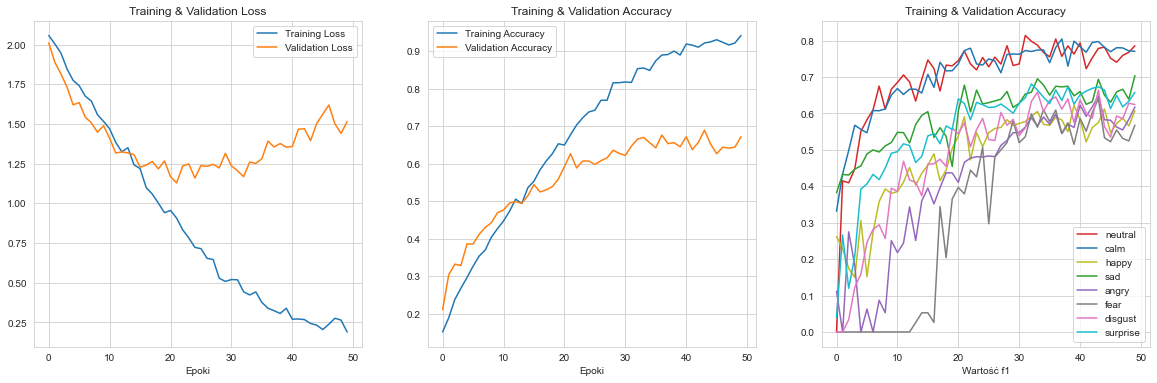

In [76]:
print("Model accuracy on test data : " , model.evaluate(x_test,y_test)[1] * 100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,3)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']
f1_score_val = history.history['val_f1_score']
# f1_avg = history.history['val_f1_avg']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

f1_score_val = np.array(f1_score_val)
colors = ['red', 'blue', 'olive', 'green', 'purple', 'gray', 'pink', 'cyan']
for i, color in enumerate(colors):
    plt.plot(epochs, f1_score_val[:, i], color=f'tab:{color}', label=f'{emotions[i+1]}')
ax[2].set_title('Training & Validation Accuracy')
ax[2].legend()
ax[2].set_xlabel("Epochs")
ax[2].set_xlabel("f1 value")
plt.show()

# Encoding of classes into strings

In [77]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

# Confusion matrix

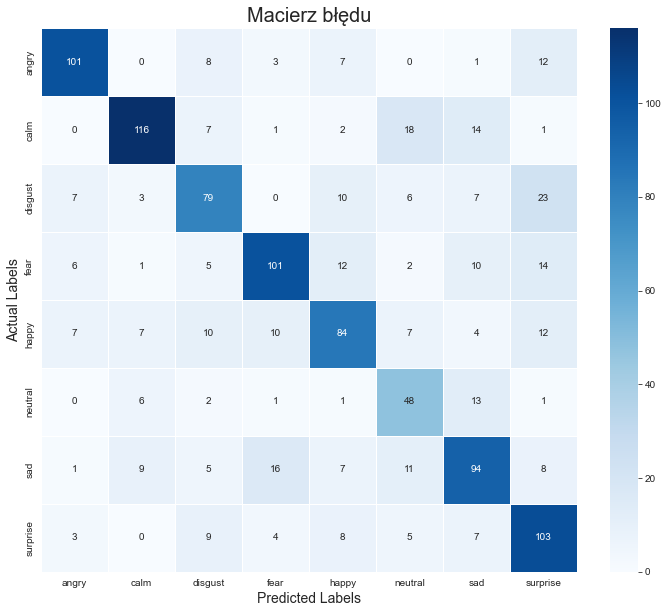

In [78]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Metrics

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.81      0.77      0.79       132
        calm       0.82      0.73      0.77       159
     disgust       0.63      0.59      0.61       135
        fear       0.74      0.67      0.70       151
       happy       0.64      0.60      0.62       141
     neutral       0.49      0.67      0.57        72
         sad       0.63      0.62      0.62       151
    surprise       0.59      0.74      0.66       139

    accuracy                           0.67      1080
   macro avg       0.67      0.67      0.67      1080
weighted avg       0.68      0.67      0.67      1080

